In [ ]:
! pip3 install pyro-ppl 
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 678 kB 9.1 MB/s 


In [ ]:
import os
os.chdir("/content/drive/MyDrive")
files = os.listdir("./")
# print(files)
if "Results" not in files:
  os.mkdir("./Results")
!ls Results/

250_100_True
250_200_True
250_500_False_simple_model_True_try_num_1
250_500_False_simple_model_True_try_num_3
250_500_True
250_500_True_simple_model_False
250_500_True_simple_model_False_try_num_1
250_500_True_simple_model_True
250_500_True_simple_model_True_try_num_1
250_500_True_simple_model_True_try_num_2
250_500_True_simple_model_True_try_num_3
250_500_True_simple_model_True_try_num_4
Test


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
import torch.nn as nn
import pyro
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model

from numpy import asarray
from numpy import savetxt

np.random.seed(33)

try_num = 4

# Size

n = 250
d = 500
# K = 100
p = 0.5


REP = 500
total_beta_sample = 1000

num_epochs = 5000
EPSILON = 1
lambda_val = 0.05
BATCH_SIZE = 64


first = True
simple_model = True

#Genarating Genotypes

toy_genotypes = binom.rvs(2, p, size=(n * 3, d))
np.random.shuffle(toy_genotypes)

print(toy_genotypes.shape)

print(np.mean(toy_genotypes))
print(np.var(toy_genotypes))



RES_DICT = {'REP': REP, 'BATCH_SIZE': BATCH_SIZE}


(750, 500)
1.000856
0.5000446005973331


In [ ]:
files = os.listdir("./Results")
save_file_name = str(n) + '_' + str(d) + '_' + str(first) + '_simple_model_' + str(simple_model) + '_try_num_' + str(try_num) 

if save_file_name not in files:
  os.mkdir("./Results/" + save_file_name)

os.chdir("Results/" + save_file_name)
!ls

best_modedl.pt				      phenotypes_dist.pdf
betas.csv				      phenotypes_dist_together.pdf
betas_sample.csv			      proposed_model_res.pdf
boxplot_greatest_values_predicted_betas.pdf   res_dict
boxplot_lowest_values_predicted_betas.pdf     test_genotypes.csv
boxplot_original_betas_greater_than_zero.pdf  test_phenotypes.csv
boxplot_original_betas_lower_than_zero.pdf    train_genotypes.csv
boxplot_original_betas_non_zero.pdf	      train_phenotypes.csv
linear_model_res.pdf			      val_genotypes.csv
phenotypes_dist_cont.pdf		      val_phenotypes.csv


In [ ]:
# test_genotypes = np.genfromtxt("test_genotypes.csv")
# train_genotypes = np.genfromtxt("train_genotypes.csv")
# val_genotypes = np.genfromtxt("val_genotypes.csv")

# test_phenotypes = np.genfromtxt("test_phenotypes.csv")
# train_phenotypes = np.genfromtxt("train_phenotypes.csv")
# val_phenotypes = np.genfromtxt("val_phenotypes.csv")

# betas = np.genfromtxt("betas.csv")

# proper_beta_samples = np.genfromtxt("betas_sample.csv")

# print(betas)
# print(betas_sample)

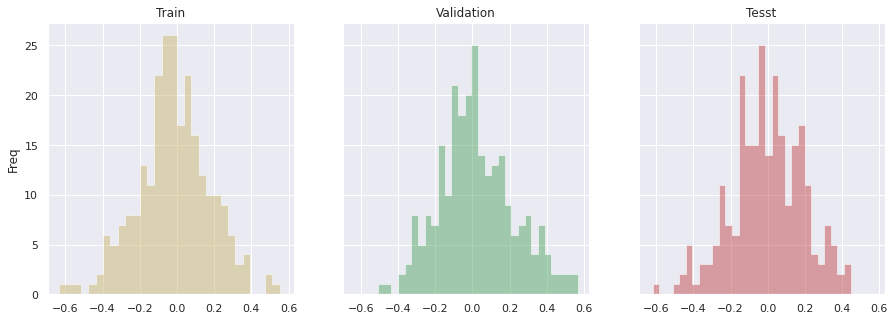

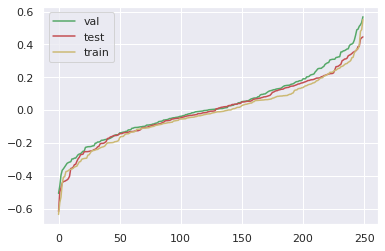

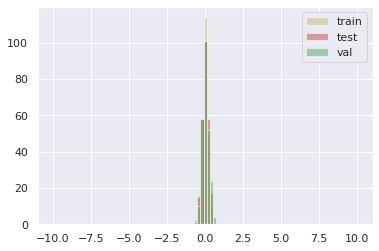

0.04569847156694837 validation
0.33674762190179586 validation correlation
6.942410690845997e-07 train
0.9999951680771616 train correlation
0.04254246017894928 test
0.37742303713772457 test correlation



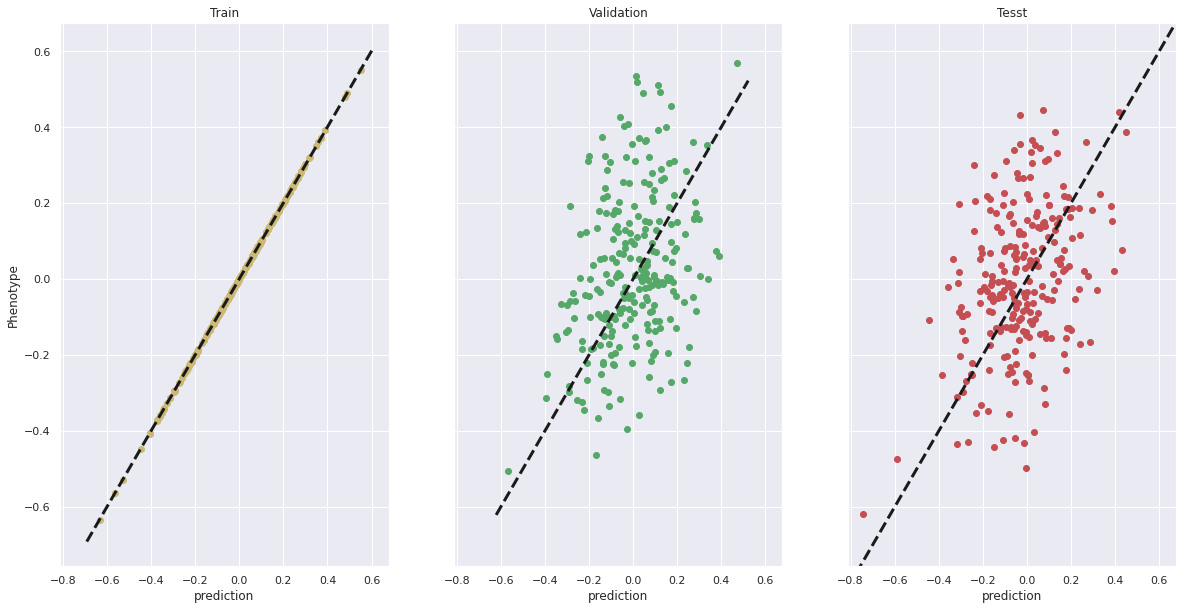

In [ ]:
def simulate_phenotypes(given_genotypes, pis=(0.95, 0.05), gammas=np.array((0., 1.)), mixture_assignment=None):
    
    
    n, p = given_genotypes.shape
    if mixture_assignment is None:
      mixture_assignment = np.random.multinomial(1, pis, size=p)
    
    std_beta = 1
    
    betas = np.random.normal(loc=0.0,
                             scale=gammas[np.where(mixture_assignment)[1]]*std_beta,
                             size=p)
    
    mult = np.dot(given_genotypes, betas)
    g_var = np.var(mult, ddof=1)
    
    e = np.random.normal(0, np.sqrt(g_var), n)
    
    y = mult + e

    y -= np.mean(y)
    y /= np.var(y)
  
    return y, betas, mixture_assignment



test_genotypes = toy_genotypes[0:n,:]
val_genotypes = toy_genotypes[n:2*n,:]
train_genotypes = toy_genotypes[2 * n:,:]

if first:

    toy_phenotypes, betas, _ = simulate_phenotypes(toy_genotypes)
    test_phenotypes = toy_phenotypes[0:n,]
    val_phenotypes = toy_phenotypes[n:2*n,]
    train_phenotypes = toy_phenotypes[2 * n:,]

    savetxt('./betas.csv', betas, delimiter=',')

    savetxt('./train_genotypes.csv', train_genotypes, delimiter=',')
    savetxt('./train_phenotypes.csv', train_phenotypes, delimiter=',')

    savetxt('./test_genotypes.csv', test_genotypes, delimiter=',')
    savetxt('./test_phenotypes.csv', test_phenotypes, delimiter=',')

    savetxt('./val_genotypes.csv', val_genotypes, delimiter=',')
    savetxt('./val_phenotypes.csv', val_phenotypes, delimiter=',')

else:
    test_phenotypes, betas_test, grand_mixture = simulate_phenotypes(test_genotypes)
    val_phenotypes, betas_val,_ = simulate_phenotypes(val_genotypes, mixture_assignment=grand_mixture)
    train_phenotypes, betas_train,_ = simulate_phenotypes(train_genotypes, mixture_assignment=grand_mixture)

    savetxt('./train_genotypes.csv', train_genotypes, delimiter=',')
    savetxt('./train_phenotypes.csv', train_phenotypes, delimiter=',')
    savetxt('./betas_train.csv', betas_train, delimiter=',')

    savetxt('./test_genotypes.csv', test_genotypes, delimiter=',')
    savetxt('./test_phenotypes.csv', test_phenotypes, delimiter=',')
    savetxt('./betas_test.csv', betas_test, delimiter=',')

    savetxt('./val_genotypes.csv', val_genotypes, delimiter=',')
    savetxt('./val_phenotypes.csv', val_phenotypes, delimiter=',')
    savetxt('./betas_val.csv', betas_val, delimiter=',')


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y', bins=30, alpha=0.5, histtype='stepfilled')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g', bins=30, alpha=0.5, histtype='stepfilled')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r', bins=30, alpha=0.5, histtype='stepfilled')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('phenotypes_dist.pdf')

plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
print("")
plt.savefig('phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('phenotypes_dist_together.pdf')
print("")
plt.show()

from sklearn import svm
from scipy.stats import pearsonr

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

per = reg.predict(val_genotypes)

# plt.xticks(np.arange(-0.5, 0.5, 0.05))
# plt.yticks(np.arange(-0.5, 0.5, 0.01))

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

# EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)


RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')
print(pearsonr(val_phenotypes, per)[0], 'validation correlation')


del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')
print(pearsonr(train_phenotypes, per)[0], 'train correlation')


del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')
print(pearsonr(test_phenotypes, per)[0], 'test correlation')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
# plt.xlim(-1,1)
plt.show()
figure.savefig('linear_model_res.pdf')






0.045919267711068655
22


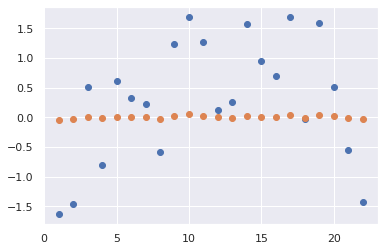

0.45220627184731327


In [ ]:

print(np.mean(np.abs(reg.coef_ - betas)))
print(len(betas[betas != 0]))
plt.scatter(np.arange(len(betas[betas != 0])) + 1, betas[betas != 0])
plt.scatter(np.arange(len(betas[betas != 0])) + 1, reg.coef_[betas != 0])

plt.show()

print(pearsonr(betas, reg.coef_)[0])

In [ ]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]        
        samples = real_samples
        labels = self.phenotypes[idx, ]
        batch = {'x': samples.astype(np.float64), 'y': labels}

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

dataset = Loader(train_genotypes, train_phenotypes)

from pyro.distributions import Normal, Gamma, MultivariateNormal
# from scipy.stats import gamma
alpha_gam = 2
beta_gam = 1

# from scipy.stats import norm


def prior_sample(size=1):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
    sigma = gamma_dist.sample(sample_shape=torch.Size([size]))
    normal_dist = Normal(0, sigma)
    beta = normal_dist.sample()
    return beta, sigma

def prior_prob(beta, sigma):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam, validate_args=True)
    p_sig = torch.exp(gamma_dist.log_prob(sigma))
    normal_dist = Normal(0, sigma)
    p_beta = torch.exp(normal_dist.log_prob(beta))
    
    return p_beta, p_sig


# from scipy.stats import multivariate_normal

def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):
    
#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_beta = MultivariateNormal(cur_beta.float(), var.float()).sample()

        new_prior, _ = prior_prob(new_beta, cur_sigma)
        new_ys = torch.matmul(geno_mat.float(), new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, geno_mat, new_prior)
            r_value = torch.mean(r_value, dim=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * new_prior

            rho = ((new_theta_prob) / (cur_prob_theta + 1e-7)).cpu().detach().numpy()
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
            if np.isnan(np.sum(rho)):
                print("EROR ------------------------")
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                # cur_sigma = cur_sigma
                cur_theta_prob = new_theta_prob
                # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1
        
        if counter > REP:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            # cur_sigma = (new_sigma + cur_sigma) / 2
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
            return cur_sigma, cur_beta, cur_theta_prob, new_ys

class Classifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        # self.layer_1 = nn.Linear(input_dim, 1)
        # self.act1 = nn.ReLU()
        self.layer_out = nn.Linear(2, 1)
        self.out = nn.LogSoftmax(dim=1)
        

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, genotypes_batch, beta, label=None):

        y = torch.tensor(y).to(device).float()
        beta = torch.Tensor(beta).to(device)[:, None].float()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        comparison_vector = torch.matmul(genotypes_batch, beta)
        
        # beta_summaries = self.act1(self.layer_1(beta))

        # x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = torch.cat([y[:, None], comparison_vector], dim=-1)

        x = self.layer_out(x)

        logits = self.out(x)

        if label is not None:

            loss = self.criterion(torch.exp(logits), label[:, None])
            return torch.exp(logits[:,-1]), loss
        
        return torch.exp(logits[:,-1]) + 1e-6
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, beta, label=None):
        y = torch.Tensor(y).to(device)
        beta = torch.Tensor(beta).to(device)
        
        y = torch.repeat_interleave(y[:, None], d, dim=-1)
        beta = torch.repeat_interleave(beta[None, :], y.shape[0], dim=0)
        x = torch.cat([beta, y], dim=-1)
        
#         out = self.linear(x)
#         out = self.activation(out)
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        if label is not None:

            loss = self.criterion(x, label[:, None])
            return x, loss
        
        return x
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


Running on the CPU
1
3


  0%|          | 0/5000 [00:00<?, ?it/s]

Best modedl changed
---------
Validation distance: 0.042819357908241526
EPOCH 0
Total Error tensor(35.7967, grad_fn=<AddBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: inv

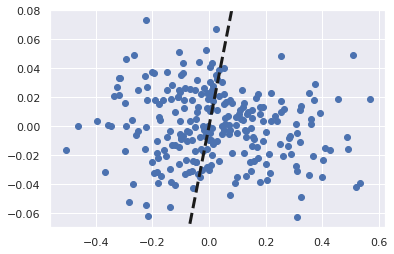

 10%|█         | 500/5000 [00:44<06:36, 11.34it/s]

---------
Validation distance: 0.16423060379485463
EPOCH 500
Total Error tensor(28.3412, grad_fn=<AddBackward0>)


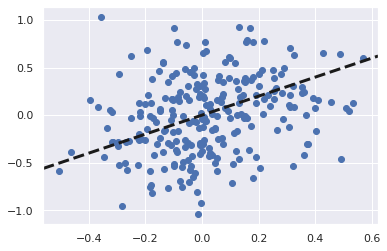

 20%|██        | 1000/5000 [01:28<05:43, 11.66it/s]

---------
Validation distance: 0.12609058586548294
EPOCH 1000
Total Error tensor(29.3150, grad_fn=<AddBackward0>)


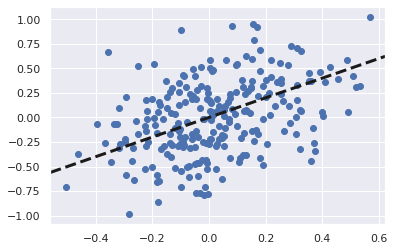

 30%|███       | 1500/5000 [02:13<05:07, 11.37it/s]

---------
Validation distance: 0.10129379274648467
EPOCH 1500
Total Error tensor(30.4701, grad_fn=<AddBackward0>)


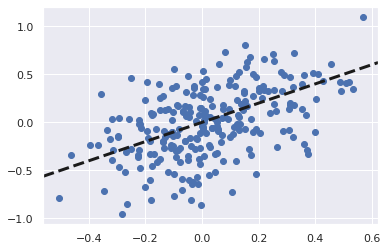

 40%|███▉      | 1999/5000 [02:58<04:18, 11.60it/s]

---------
Validation distance: 0.06487539036111992
EPOCH 2000
Total Error tensor(25.1298, grad_fn=<AddBackward0>)


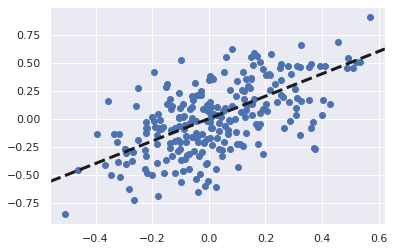

 45%|████▌     | 2274/5000 [03:22<04:05, 11.12it/s]

Best modedl changed


 46%|████▌     | 2292/5000 [03:24<04:01, 11.21it/s]

Best modedl changed


 46%|████▌     | 2300/5000 [03:25<04:05, 10.99it/s]

Best modedl changed


 46%|████▌     | 2306/5000 [03:25<04:07, 10.88it/s]

Best modedl changed


 46%|████▌     | 2310/5000 [03:26<04:01, 11.14it/s]

Best modedl changed


 46%|████▋     | 2318/5000 [03:26<03:53, 11.48it/s]

Best modedl changed


 47%|████▋     | 2328/5000 [03:27<04:04, 10.94it/s]

Best modedl changed


 47%|████▋     | 2332/5000 [03:28<04:04, 10.89it/s]

Best modedl changed


 47%|████▋     | 2370/5000 [03:31<03:55, 11.19it/s]

Best modedl changed


 47%|████▋     | 2374/5000 [03:31<03:59, 10.95it/s]

Best modedl changed


 48%|████▊     | 2410/5000 [03:35<03:55, 11.00it/s]

Best modedl changed


 48%|████▊     | 2422/5000 [03:36<03:58, 10.82it/s]

Best modedl changed
Best modedl changed


 49%|████▊     | 2432/5000 [03:37<03:48, 11.22it/s]

Best modedl changed


 49%|████▊     | 2436/5000 [03:37<03:43, 11.45it/s]

Best modedl changed


 49%|████▉     | 2442/5000 [03:38<03:47, 11.26it/s]

Best modedl changed


 49%|████▉     | 2462/5000 [03:39<03:47, 11.14it/s]

Best modedl changed


 50%|████▉     | 2484/5000 [03:41<03:52, 10.84it/s]

Best modedl changed


 50%|████▉     | 2486/5000 [03:42<03:54, 10.74it/s]

Best modedl changed
Best modedl changed


 50%|████▉     | 2490/5000 [03:42<03:53, 10.75it/s]

Best modedl changed
Best modedl changed
Best modedl changed


 50%|████▉     | 2492/5000 [03:42<03:53, 10.73it/s]

Best modedl changed
Best modedl changed


 50%|█████     | 2500/5000 [03:43<03:41, 11.31it/s]

Best modedl changed
---------
Validation distance: 0.036045352326966
EPOCH 2500
Total Error tensor(35.6959, grad_fn=<AddBackward0>)


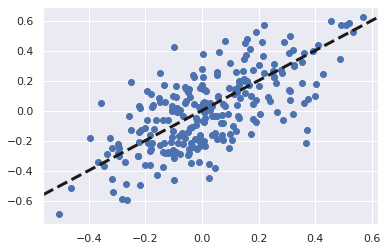

 50%|█████     | 2510/5000 [03:44<04:46,  8.68it/s]

Best modedl changed
Best modedl changed
Best modedl changed


 50%|█████     | 2518/5000 [03:45<03:53, 10.62it/s]

Best modedl changed


 50%|█████     | 2524/5000 [03:45<03:41, 11.17it/s]

Best modedl changed


 51%|█████     | 2528/5000 [03:46<03:43, 11.04it/s]

Best modedl changed


 51%|█████     | 2532/5000 [03:46<03:50, 10.69it/s]

Best modedl changed


 51%|█████     | 2546/5000 [03:47<03:47, 10.78it/s]

Best modedl changed
Best modedl changed


 51%|█████     | 2550/5000 [03:48<03:52, 10.55it/s]

Best modedl changed


 51%|█████▏    | 2564/5000 [03:49<03:38, 11.13it/s]

Best modedl changed
Best modedl changed


 51%|█████▏    | 2568/5000 [03:50<03:38, 11.12it/s]

Best modedl changed


 52%|█████▏    | 2576/5000 [03:50<03:54, 10.33it/s]

Best modedl changed


 52%|█████▏    | 2578/5000 [03:50<03:52, 10.42it/s]

Best modedl changed
Best modedl changed


 52%|█████▏    | 2580/5000 [03:51<03:56, 10.22it/s]

Best modedl changed
Best modedl changed


 52%|█████▏    | 2583/5000 [03:51<04:06,  9.79it/s]

Best modedl changed
Best modedl changed


 52%|█████▏    | 2587/5000 [03:51<03:51, 10.44it/s]

Best modedl changed


 52%|█████▏    | 2589/5000 [03:52<03:52, 10.37it/s]

Best modedl changed
Best modedl changed


 52%|█████▏    | 2595/5000 [03:52<03:44, 10.71it/s]

Best modedl changed


 52%|█████▏    | 2599/5000 [03:53<03:53, 10.27it/s]

Best modedl changed


 52%|█████▏    | 2621/5000 [03:55<03:33, 11.12it/s]

Best modedl changed


 53%|█████▎    | 2645/5000 [03:57<03:27, 11.34it/s]

Best modedl changed


 53%|█████▎    | 2655/5000 [03:58<03:31, 11.11it/s]

Best modedl changed


 53%|█████▎    | 2671/5000 [03:59<03:37, 10.71it/s]

Best modedl changed
Best modedl changed
Best modedl changed


 53%|█████▎    | 2673/5000 [03:59<03:35, 10.80it/s]

Best modedl changed
Best modedl changed


 54%|█████▎    | 2677/5000 [04:00<03:34, 10.85it/s]

Best modedl changed


 54%|█████▍    | 2689/5000 [04:01<03:25, 11.25it/s]

Best modedl changed


 54%|█████▍    | 2693/5000 [04:01<03:28, 11.09it/s]

Best modedl changed


 54%|█████▍    | 2705/5000 [04:02<03:34, 10.69it/s]

Best modedl changed


 54%|█████▍    | 2707/5000 [04:02<03:39, 10.45it/s]

Best modedl changed


 54%|█████▍    | 2719/5000 [04:03<03:21, 11.31it/s]

Best modedl changed


 54%|█████▍    | 2723/5000 [04:04<03:33, 10.66it/s]

Best modedl changed


 55%|█████▍    | 2731/5000 [04:05<03:19, 11.40it/s]

Best modedl changed


 55%|█████▍    | 2735/5000 [04:05<03:20, 11.29it/s]

Best modedl changed


 55%|█████▍    | 2743/5000 [04:06<03:24, 11.03it/s]

Best modedl changed


 55%|█████▍    | 2749/5000 [04:06<03:25, 10.97it/s]

Best modedl changed


 55%|█████▌    | 2753/5000 [04:07<03:22, 11.11it/s]

Best modedl changed


 55%|█████▌    | 2761/5000 [04:07<03:23, 11.03it/s]

Best modedl changed


 56%|█████▌    | 2799/5000 [04:11<03:21, 10.90it/s]

Best modedl changed


 56%|█████▌    | 2803/5000 [04:11<03:17, 11.13it/s]

Best modedl changed


 57%|█████▋    | 2843/5000 [04:15<03:14, 11.06it/s]

Best modedl changed


 58%|█████▊    | 2917/5000 [04:21<03:04, 11.31it/s]

Best modedl changed


 58%|█████▊    | 2923/5000 [04:22<03:00, 11.49it/s]

Best modedl changed


 59%|█████▉    | 2953/5000 [04:24<03:06, 10.97it/s]

Best modedl changed


 59%|█████▉    | 2971/5000 [04:26<03:00, 11.22it/s]

Best modedl changed


 60%|█████▉    | 2999/5000 [04:28<02:57, 11.26it/s]

---------
Validation distance: 0.02839533758711859
EPOCH 3000
Total Error tensor(31.8796, grad_fn=<AddBackward0>)


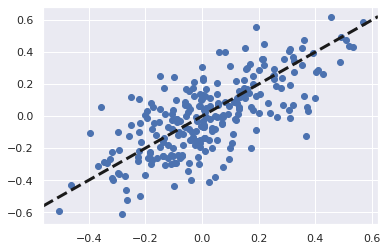

 61%|██████    | 3029/5000 [04:31<02:57, 11.08it/s]

Best modedl changed


 61%|██████    | 3033/5000 [04:32<03:02, 10.79it/s]

Best modedl changed


 61%|██████    | 3059/5000 [04:34<02:51, 11.31it/s]

Best modedl changed


 61%|██████▏   | 3065/5000 [04:35<02:51, 11.28it/s]

Best modedl changed


 62%|██████▏   | 3077/5000 [04:36<02:53, 11.07it/s]

Best modedl changed


 63%|██████▎   | 3141/5000 [04:42<02:45, 11.25it/s]

Best modedl changed


 63%|██████▎   | 3149/5000 [04:42<02:46, 11.13it/s]

Best modedl changed


 64%|██████▍   | 3201/5000 [04:47<02:44, 10.93it/s]

Best modedl changed


 65%|██████▍   | 3249/5000 [04:51<02:33, 11.38it/s]

Best modedl changed


 66%|██████▌   | 3291/5000 [04:55<02:37, 10.85it/s]

Best modedl changed


 66%|██████▌   | 3307/5000 [04:56<02:46, 10.16it/s]

Best modedl changed


 67%|██████▋   | 3349/5000 [05:00<02:35, 10.62it/s]

Best modedl changed


 68%|██████▊   | 3387/5000 [05:04<02:29, 10.80it/s]

Best modedl changed


 69%|██████▉   | 3457/5000 [05:10<02:22, 10.79it/s]

Best modedl changed


 70%|██████▉   | 3479/5000 [05:12<02:17, 11.10it/s]

Best modedl changed


 70%|██████▉   | 3499/5000 [05:14<02:16, 11.01it/s]

---------
Validation distance: 0.026972295334627795
EPOCH 3500
Total Error tensor(30.5932, grad_fn=<AddBackward0>)


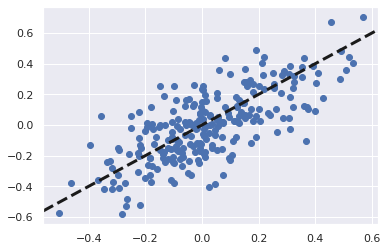

 70%|███████   | 3513/5000 [05:16<02:27, 10.09it/s]

Best modedl changed


 71%|███████▏  | 3573/5000 [05:21<02:03, 11.57it/s]

Best modedl changed


 72%|███████▏  | 3581/5000 [05:22<02:07, 11.11it/s]

Best modedl changed


 75%|███████▍  | 3727/5000 [05:35<01:53, 11.22it/s]

Best modedl changed


 75%|███████▌  | 3759/5000 [05:38<01:55, 10.79it/s]

Best modedl changed


 76%|███████▌  | 3785/5000 [05:40<01:55, 10.55it/s]

Best modedl changed


 76%|███████▌  | 3791/5000 [05:41<01:58, 10.19it/s]

Best modedl changed


 76%|███████▌  | 3797/5000 [05:41<01:53, 10.56it/s]

Best modedl changed


 76%|███████▋  | 3823/5000 [05:44<01:53, 10.38it/s]

Best modedl changed


 79%|███████▊  | 3933/5000 [05:53<01:32, 11.59it/s]

Best modedl changed


 79%|███████▉  | 3943/5000 [05:54<01:33, 11.29it/s]

Best modedl changed


 80%|███████▉  | 3999/5000 [05:59<01:31, 10.95it/s]

---------
Validation distance: 0.025853752272785323
EPOCH 4000
Total Error tensor(29.5389, grad_fn=<AddBackward0>)


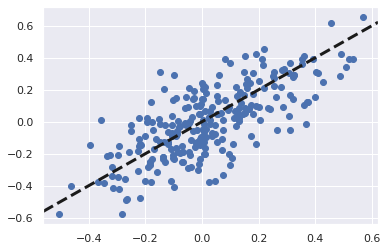

 81%|████████  | 4029/5000 [06:02<01:31, 10.62it/s]

Best modedl changed


 81%|████████  | 4045/5000 [06:04<01:27, 10.91it/s]

Best modedl changed


 82%|████████▏ | 4079/5000 [06:07<01:25, 10.77it/s]

Best modedl changed


 82%|████████▏ | 4121/5000 [06:11<01:21, 10.76it/s]

Best modedl changed


 83%|████████▎ | 4135/5000 [06:12<01:19, 10.88it/s]

Best modedl changed


 84%|████████▎ | 4181/5000 [06:16<01:13, 11.11it/s]

Best modedl changed


 84%|████████▎ | 4185/5000 [06:17<01:15, 10.77it/s]

Best modedl changed


 86%|████████▋ | 4325/5000 [06:29<01:03, 10.64it/s]

Best modedl changed


 90%|████████▉ | 4489/5000 [06:44<00:45, 11.32it/s]

Best modedl changed


 90%|████████▉ | 4499/5000 [06:45<00:44, 11.27it/s]

---------
Validation distance: 0.02517048840407837
EPOCH 4500
Total Error tensor(28.9188, grad_fn=<AddBackward0>)


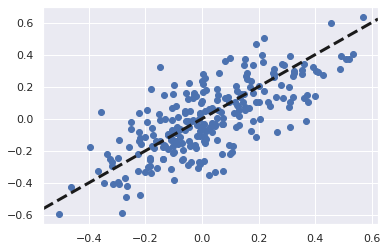

 92%|█████████▏| 4596/5000 [06:54<00:35, 11.47it/s]

Best modedl changed


 92%|█████████▏| 4612/5000 [06:55<00:35, 11.06it/s]

Best modedl changed


 94%|█████████▍| 4722/5000 [07:05<00:25, 11.02it/s]

Best modedl changed
Best modedl changed


 95%|█████████▍| 4742/5000 [07:07<00:23, 11.05it/s]

Best modedl changed


 95%|█████████▌| 4758/5000 [07:09<00:22, 10.83it/s]

Best modedl changed


 96%|█████████▋| 4814/5000 [07:14<00:17, 10.86it/s]

Best modedl changed


 97%|█████████▋| 4832/5000 [07:15<00:14, 11.39it/s]

Best modedl changed


 97%|█████████▋| 4838/5000 [07:16<00:15, 10.66it/s]

Best modedl changed


 98%|█████████▊| 4886/5000 [07:20<00:10, 11.06it/s]

Best modedl changed


 98%|█████████▊| 4914/5000 [07:23<00:07, 11.15it/s]

Best modedl changed


 99%|█████████▊| 4936/5000 [07:25<00:05, 10.76it/s]

Best modedl changed


 99%|█████████▉| 4950/5000 [07:26<00:04, 10.55it/s]

Best modedl changed
Best modedl changed


100%|██████████| 5000/5000 [07:31<00:00, 11.08it/s]


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

print(EPSILON)


data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

if simple_model:
  classifier = Classifier(d).to(device)
else:
  classifier = LogisticRegression(d * 2).to(device)

print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []

denum = train_genotypes.shape[0] / BATCH_SIZE

losses = []


# Sampling beta
proper_beta_samples = []
proper_beta_samples_distances = []
counter = 0

RES_DICT['total_beta_sample'] = total_beta_sample


distance = -1


##### Saving
min_dist = 999
best_model = None

for epoch in tqdm(range(num_epochs)):
    
    error_sum = 0
    distance_sum = 0
    
#     var = np.eye(d) * (0.75 / (epoch + 1))
    var = torch.tensor(np.eye(d) * 0.0008, dtype=torch.float64)

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(train_genotypes, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    cur_prior, _ = prior_prob(torch.tensor(cur_beta), torch.tensor(cur_sigma))
    cur_r_value = classifier(cur_ys, train_genotypes.astype(np.float64), cur_beta).cpu().detach().numpy()
    cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * cur_prior

    proper_beta_samples_dist = {}

    for n_batch, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        N = batch['x'].size(0)
        
        geno_batch = batch['x']
        pheno_batch = batch['y']
        
        sampled_sigma, sampled_beta, prob_theta, sampled_y = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()
        
#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()

        # sampled_y *= -1

        distance = torch.mean((sampled_y - pheno_batch) ** 2)
        
#         print(distance)
        distance_sum += distance
        
        _, loss_f = classifier(sampled_y, geno_batch, sampled_beta, torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, geno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
        
#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))
                             
#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))
        
        loss = loss_f + loss_r
        loss *= (distance ** 2)

        loss += (lambda_val * torch.sum(torch.abs(sampled_beta)) / d + torch.mean((sampled_beta - betas) ** 2))

        loss.backward()

        optimizer.step()
        error_sum += loss

        proper_beta_samples_dist[distance] = sampled_beta.cpu().detach().numpy()
            
        cur_beta = sampled_beta.clone()
        cur_sigma = sampled_sigma.clone()
        cur_theta_prob = prob_theta
    
    proper_beta_samples_val = np.array(proper_beta_samples)
    proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)
    
    if len(proper_beta_samples) > 0:
            # print("Using proper sets")
            proper_beta_samples_val = np.array(proper_beta_samples)
            proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)
            proper_beta_samples_val.shape

            val_y = np.dot(val_genotypes, proper_beta_samples_val)

    else:   
            val_y = np.dot(val_genotypes, sampled_beta)
  
    val_y -= np.mean(val_y)
    val_y /= np.var(val_y)

    val_distance = np.mean((val_y - val_phenotypes) ** 2)

    if min_dist > val_distance:
      min_dist = val_distance
      best_model = torch.save(classifier.state_dict(), "./best_modedl.pt")
      print("Best modedl changed")
    

    # Sampling beta based on validation datasets

    beta_validation_sample_dist = {}
    for _,samp_item in proper_beta_samples_dist.items():
      examine_val = np.dot(val_genotypes, samp_item)
      examine_val -= np.mean(examine_val)
      examine_val /= np.var(examine_val)

      examine_val_distance = np.mean((examine_val - val_phenotypes) ** 2)

      beta_validation_sample_dist[examine_val_distance] = samp_item
    
    items_sorted = sorted(beta_validation_sample_dist.keys(), reverse=True)

    if counter < total_beta_sample:
      empty = total_beta_sample - counter
      for i in range(empty):
        if i >= len(items_sorted):
          break
        # print(beta_validation_sample_dist[items_sorted[i]])
        proper_beta_samples.append(beta_validation_sample_dist[items_sorted[i]])
        proper_beta_samples_distances.append(items_sorted[i])
        counter += 1

    else:
      for dist_key in items_sorted:

        beta_value = beta_validation_sample_dist[dist_key]
        if dist_key < proper_beta_samples_distances[-1]:
          this_value_add = proper_beta_samples_distances[-1]
          counter_loop = total_beta_sample - 1
          while(dist_key < this_value_add):
            counter_loop -= 1
            if counter_loop < 0:
              proper_beta_samples.insert(0,beta_value)
              proper_beta_samples.pop(-1)
              proper_beta_samples_distances.insert(0, dist_key)
              proper_beta_samples_distances.pop(-1)
              break
            if proper_beta_samples_distances[counter_loop] < dist_key:
              proper_beta_samples.insert(counter_loop + 1, beta_value)
              proper_beta_samples.pop(-1)
              proper_beta_samples_distances.insert(counter_loop + 1, dist_key)
              proper_beta_samples_distances.pop(-1)
              break
          else:
            break
    
    if (epoch % int(num_epochs / 10) == 0 and epoch >= int(num_epochs / 10)) or epoch == 0:
        print("---------")
        print("Validation distance:", val_distance)
        print("EPOCH", epoch)
        print("Total Error", error_sum)


        plt.scatter(val_phenotypes, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)
        
    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])
        

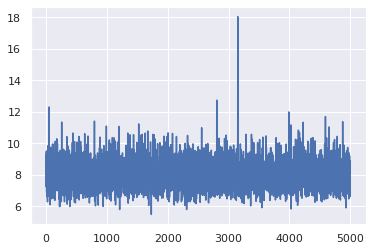

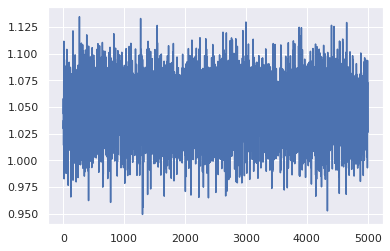

1.0460073517649198


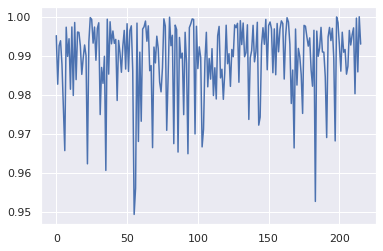

In [ ]:
plt.plot(np.arange(epoch + 1), losses)
plt.show()
plt.plot(np.arange(epoch + 1), distances)
plt.show()
distances = np.array(distances)
plt.plot(np.arange(len(distances[distances < EPSILON])), distances[distances < EPSILON])
print(np.mean(distances))
plt.show()

(1000, 500)
(500,)
211


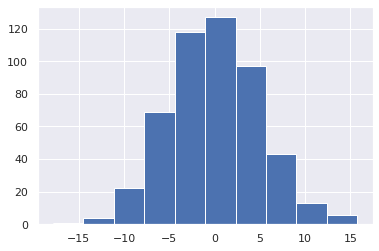

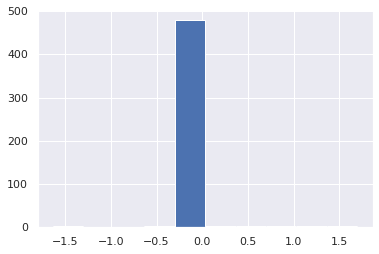

In [ ]:
savetxt('./betas_sample.csv', proper_beta_samples, delimiter=',')

proper_beta_samples_np = np.array(proper_beta_samples).T

# proper_beta_samples_np -= np.mean(proper_beta_samples_np, axis=1)
# proper_beta_samples_np /= np.var(proper_beta_samples_np, axis=1)

print(proper_beta_samples_np.T.shape)
proper_beta_samples_mean = np.mean(proper_beta_samples_np.T, axis=0)
print(proper_beta_samples_mean.shape)

proper_beta_samples_mean -= np.mean(proper_beta_samples_mean)
proper_beta_samples_mean /= np.var(proper_beta_samples_mean)
proper_beta_samples_mean[np.abs(proper_beta_samples_mean) < 0.9] = 0
print(len(proper_beta_samples_mean[proper_beta_samples_mean > 0]))

if first:
    plt.hist(proper_beta_samples_mean)
    plt.show()
    plt.hist(betas)
    plt.show()
else:
    plt.hist(proper_beta_samples_mean)
    plt.show()
    plt.hist(betas_train)
    plt.show()


15
(1000,)


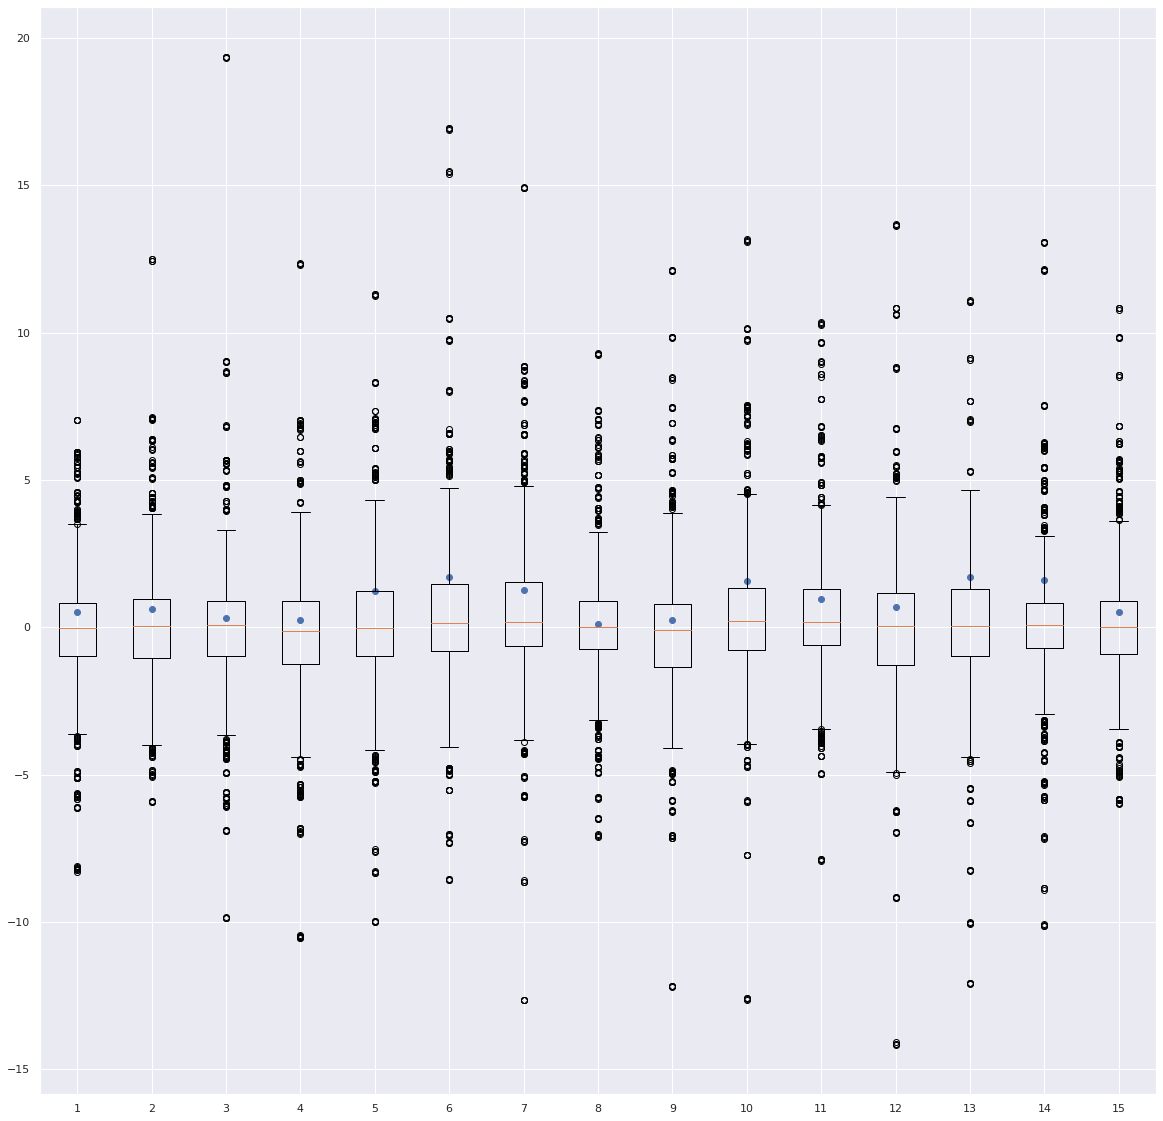

7
(1000,)


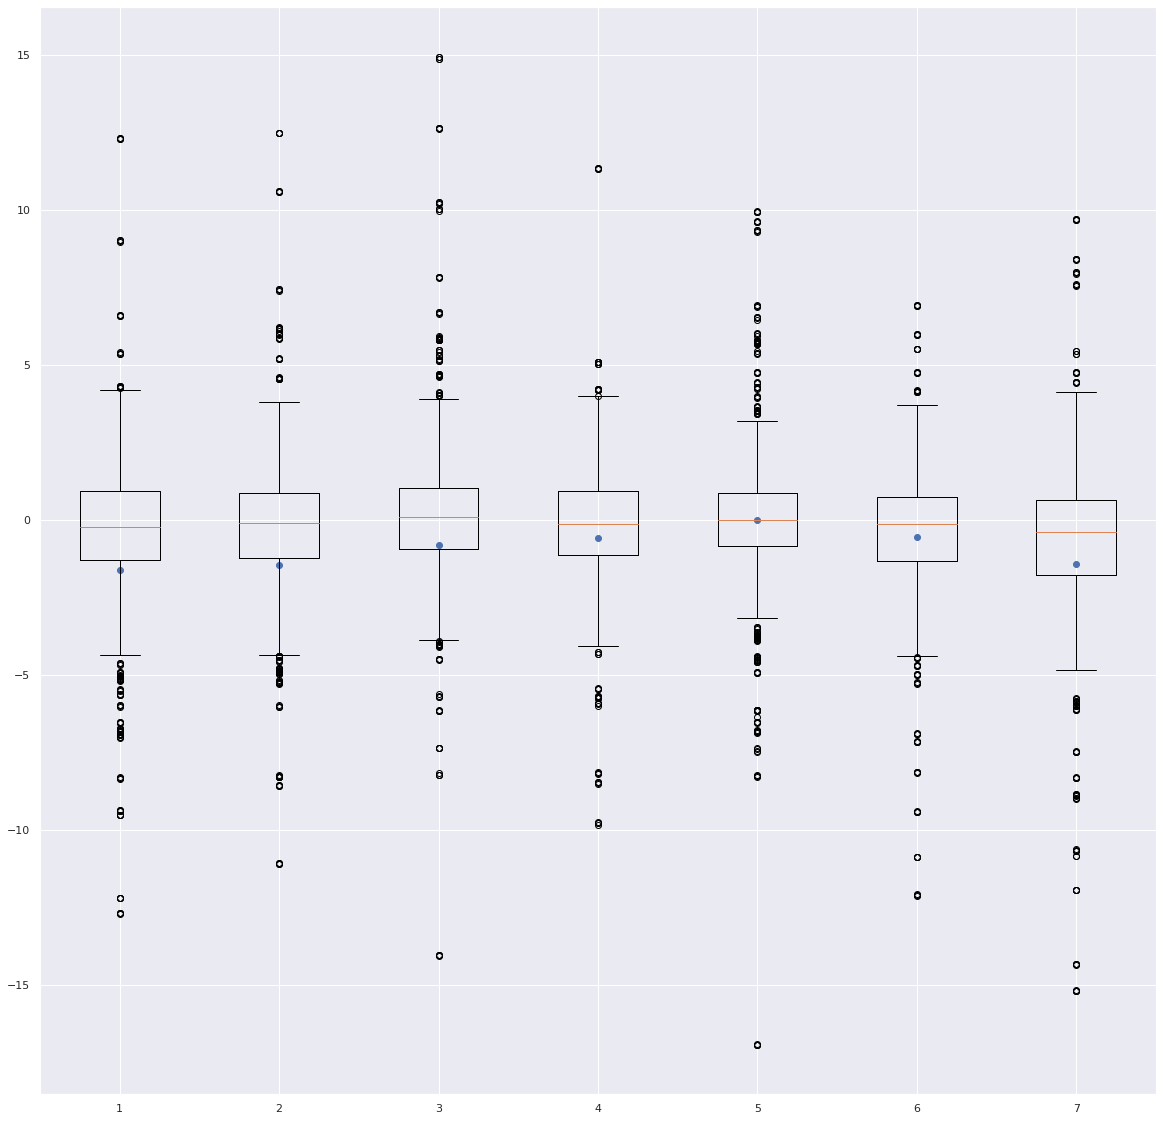

22
(1000,)


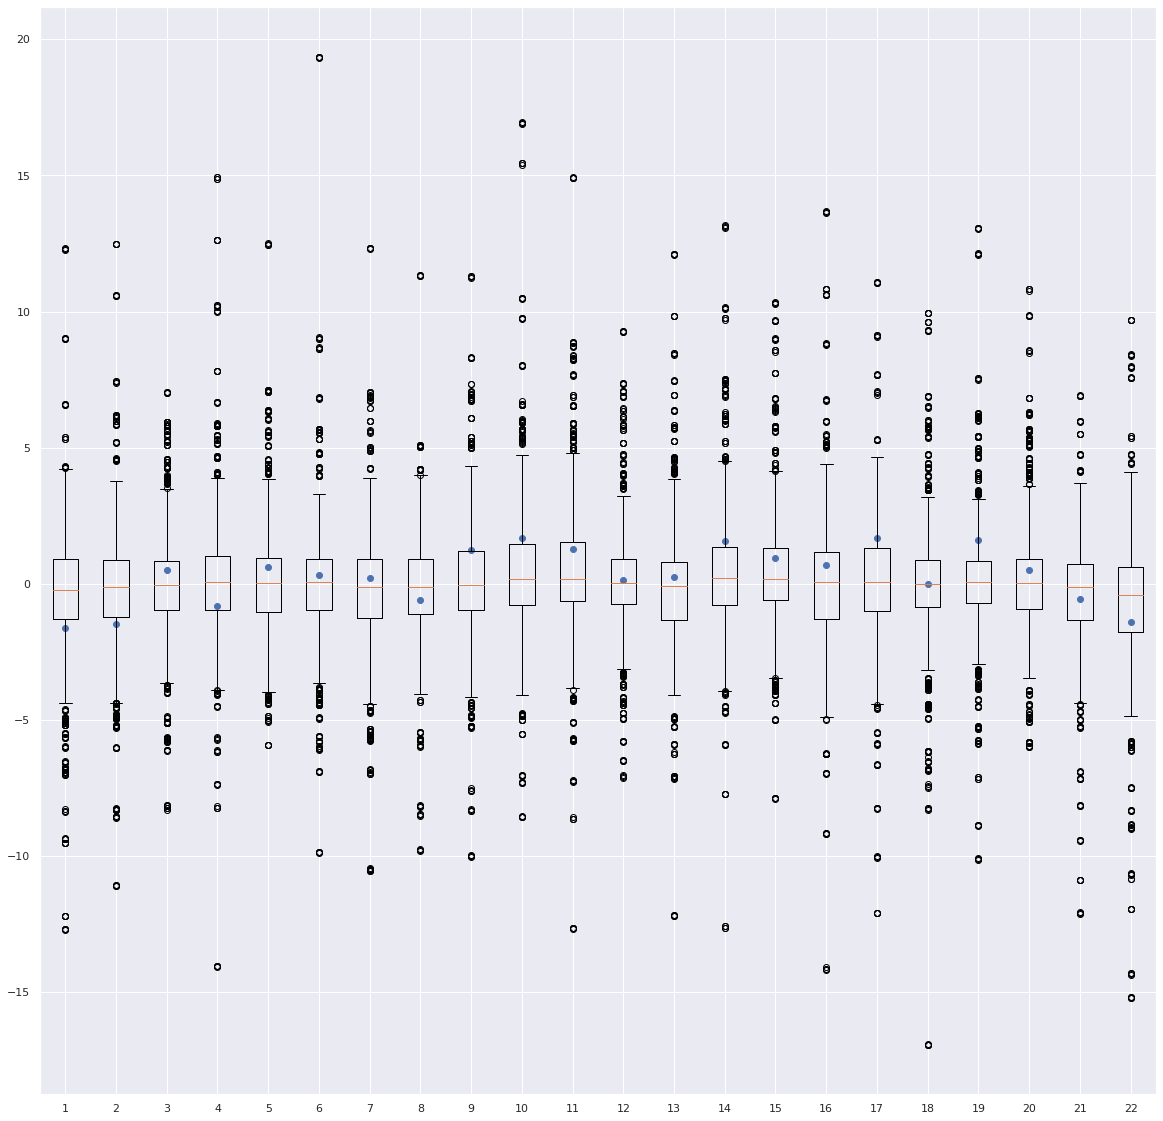

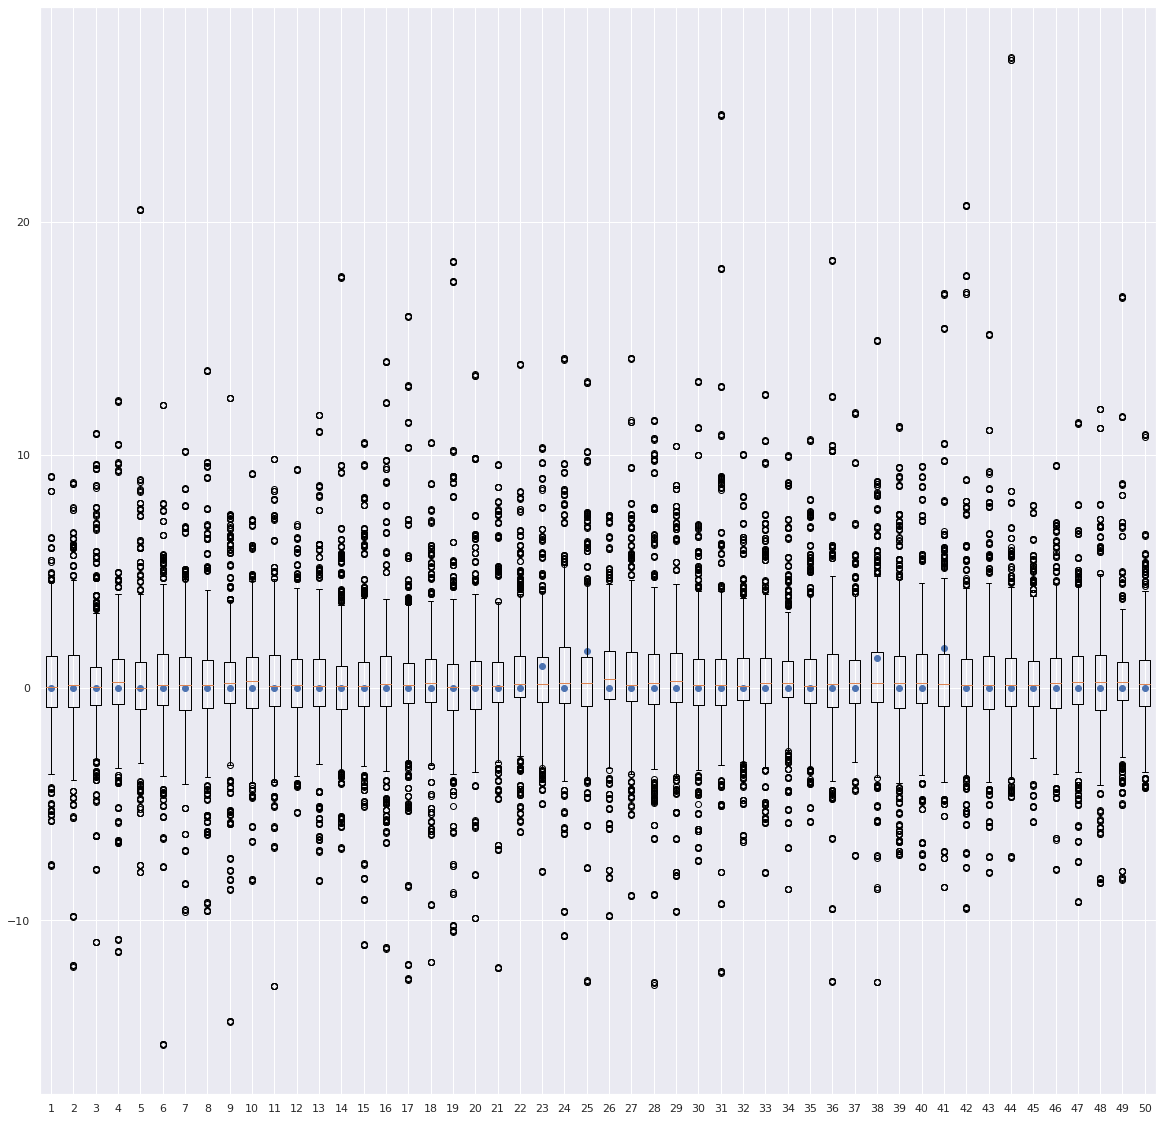

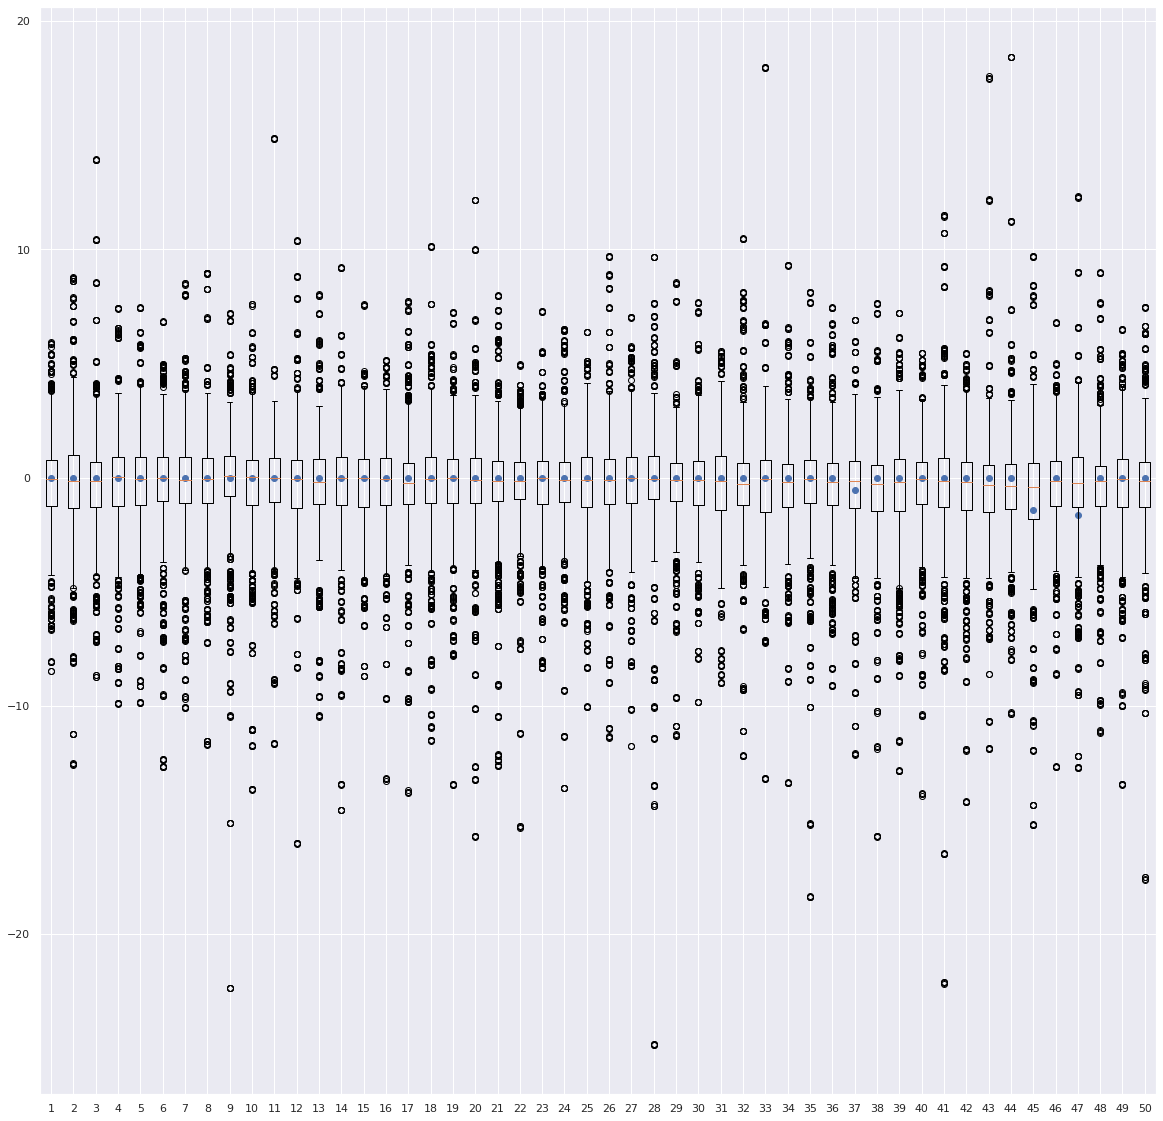

In [ ]:
show_case = 50
threshold_filtering = 0.6

if first:

    to_plot = []
    for i in range(proper_beta_samples_np[betas > 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas > 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas > 0])
    fig.savefig('boxplot_original_betas_greater_than_zero.pdf',bbox_inches='tight')
    plt.show()

    to_plot = []
    for i in range(proper_beta_samples_np[betas < 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas < 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas < 0])
    fig.savefig('boxplot_original_betas_lower_than_zero.pdf',bbox_inches='tight')
    plt.show()


    to_plot = []
    for i in range(proper_beta_samples_np[betas != 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas != 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas!=0])
    fig.savefig('boxplot_original_betas_non_zero.pdf',bbox_inches='tight')
    plt.show()



    # to_plot = []
    # for i in range(proper_beta_samples_np[proper_beta_samples_mean > threshold_filtering].shape[0]):
    #     to_plot += [proper_beta_samples_np[proper_beta_samples_mean > threshold_filtering][i, :]]

    # print(len(to_plot))
    # print(to_plot[0].shape)
    # fig=plt.figure(1,figsize=(20,20))
    # ax=fig.add_subplot(111)
    # bp=ax.boxplot(to_plot)

    # plt.scatter(np.arange(len(to_plot)) + 1, betas[proper_beta_samples_mean > threshold_filtering])
    # fig.savefig('boxplot_predicted_betas_greater_than_zero.pdf',bbox_inches='tight')
    # plt.show()


    # ind = np.argpartition(np.abs(proper_beta_samples_mean), -int(show_case))[-int(show_case):]
    ind = np.argpartition(proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas[ind])
    fig.savefig('boxplot_greatest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


    ind = np.argpartition(-1 * proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas[ind])
    fig.savefig('boxplot_lowest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


else:
    to_plot = []
    for i in range(proper_beta_samples_np[betas_train > 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train > 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train > 0])
    fig.savefig('boxplot_original_betas_greater_than_zero.pdf',bbox_inches='tight')
    plt.show()

    to_plot = []
    for i in range(proper_beta_samples_np[betas_train < 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train < 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train < 0])
    fig.savefig('boxplot_original_betas_lower_than_zero.pdf',bbox_inches='tight')
    plt.show()


    to_plot = []
    for i in range(proper_beta_samples_np[betas_train != 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train != 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train!=0])
    fig.savefig('boxplot_original_betas_non_zero.pdf',bbox_inches='tight')
    plt.show()


    # ind = np.argpartition(np.abs(proper_beta_samples_mean), -int(show_case))[-int(show_case):]
    ind = np.argpartition(proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas_train[ind])
    fig.savefig('boxplot_greatest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


    ind = np.argpartition(-1 * proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas_train[ind])
    fig.savefig('boxplot_lowest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


0.03871592534480613 validation
0.7297370203243765 validation correlation
0.03726913834499557 train
0.12780145724200392 train correlation
0.036602406798065173 test
0.2351264761059126 test correlation


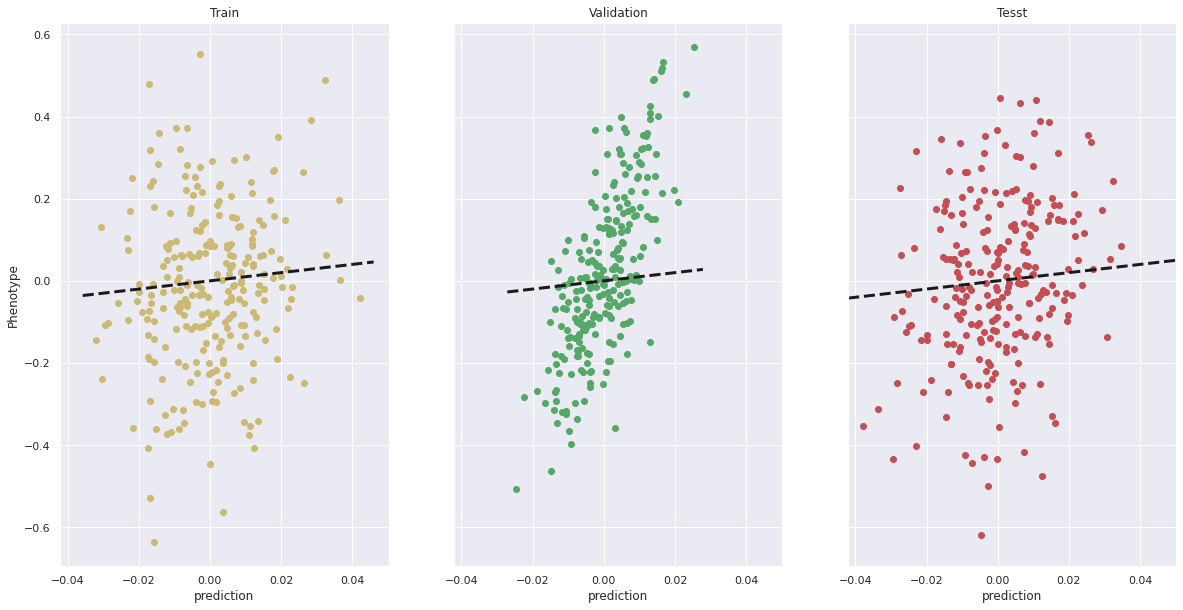

3.8458447942842144


In [ ]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

# del per
per = np.dot(val_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')
print(pearsonr(val_phenotypes, per)[0], 'validation correlation')

del per

per = np.dot(train_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')
print(pearsonr(train_phenotypes, per)[0], 'train correlation')


del per

per = np.dot(test_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')
print(pearsonr(test_phenotypes, per)[0], 'test correlation')


for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

# plt.xlim(-1,1)
plt.show()
figure.savefig('proposed_model_res.pdf')


if first:
    print(np.mean(np.abs(proper_beta_samples_mean - betas)))
else:
    print(np.mean(np.abs(proper_beta_samples_mean - betas_train)))
    print(np.mean(np.abs(proper_beta_samples_mean - betas_test)))
    print(np.mean(np.abs(proper_beta_samples_mean - betas_val)))


In [ ]:
import pickle
    
try:
    res_file = open('res_dict', 'wb')
    pickle.dump(RES_DICT, res_file)
    res_file.close()
  
except:
    print("Something went wrong")

In [ ]:
betas

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.63515585,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  